In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from matplotlib.ticker import PercentFormatter

from pathlib import Path
import seaborn as sns
import scipy.stats as ss

from sklearn import preprocessing 
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [2]:
raw_df = pd.read_csv('bank-full.csv', header= 0, delimiter= ";")
raw_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [3]:
raw_df.shape

(45211, 17)

In [4]:
raw_df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [5]:
raw_df.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

In [6]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


## Attribute Information:

Input variables:
#### bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - balance: average yearly balance, in euros (numeric) 
7 - housing: has housing loan? (categorical: 'no','yes','unknown')
8 - loan: has personal loan? (categorical: 'no','yes','unknown')
#### related with the last contact of the current campaign:
9 - contact: contact communication type (categorical: 'cellular','telephone')
10 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
11 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
12 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
##### other attributes:
13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
15 - previous: number of contacts performed before this campaign and for this client (numeric)
16 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')


#### Output variable (desired target):
17 - y - has the client subscribed a term deposit? (binary: 'yes','no')

Defining the two major kinds of column types for the EDA: numerical (num_col) and categorical (cat_col) data types. The categorical data also includes boolean categories.

In [7]:
num_col = ['age', "balance", 'day', 'duration', 'campaign', 'previous']
cat_col = ['job', 'marital', 'education', 'contact', 'month', 'poutcome', 'default', 'housing', 'loan', 'pdays_cat', 'y_bool']

In [8]:
num_of_days = pd.cut(raw_df.pdays, bins=[-2, 0, 120, 365, 9999], labels=['no contact', '3 months', '1 year', 'more than 1 year'])
num_of_days.value_counts()

no contact          36954
1 year               5715
3 months             1899
more than 1 year      643
Name: pdays, dtype: int64

In [9]:
raw_df['pdays_cat'] = num_of_days
raw_df = raw_df.astype({'pdays_cat': str})
raw_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,pdays_cat
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no,no contact
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no,no contact
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no,no contact
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no,no contact
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no,no contact


In [13]:
outcome = raw_df['y']
outcome.replace('no', 0, inplace=True)
outcome.replace('yes', 1, inplace=True)
outcome.value_counts()

0    39922
1     5289
Name: y, dtype: int64

In [14]:
raw_df['y_bool'] = outcome
raw_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,pdays_cat,y_bool
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,0,no contact,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,0,no contact,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,0,no contact,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,0,no contact,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,0,no contact,0


In [15]:
raw_df['cust_id'] = raw_df.index
raw_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,pdays_cat,y_bool,cust_id
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,0,no contact,0,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,0,no contact,0,1
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,0,no contact,0,2
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,0,no contact,0,3
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,0,no contact,0,4


In [16]:
jobs = raw_df['job']
jobs.replace('blue-collar', 'blueCollar', inplace=True)
jobs.replace('self-employed', 'selfEmployed', inplace=True)
jobs.replace('admin.', 'admin', inplace=True)
jobs.value_counts()

blueCollar      9732
management      9458
technician      7597
admin           5171
services        4154
retired         2264
selfEmployed    1579
entrepreneur    1487
unemployed      1303
housemaid       1240
student          938
unknown          288
Name: job, dtype: int64

In [17]:
raw_df['job'] = jobs
raw_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,pdays_cat,y_bool,cust_id
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,0,no contact,0,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,0,no contact,0,1
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,0,no contact,0,2
3,47,blueCollar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,0,no contact,0,3
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,0,no contact,0,4


In [18]:
raw_df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
pdays_cat    0
y_bool       0
cust_id      0
dtype: int64

In [19]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  int64 
 17  pdays_cat  45211 non-null  object
 18  y_bool     45211 non-null  int64 
 19  cust_id    45211 non-null  int64 
dtypes: int64(10), object(10)
mem

# Splitting into train, test set

In [20]:
df_train, df_test = train_test_split(raw_df, test_size=0.3, random_state= 42)

In [21]:
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [22]:
df_train.shape,df_test.shape

((31647, 20), (13564, 20))

In [23]:
round(df_train.y_bool.mean(),3),round(df_test.y_bool.mean(),3)

(0.117, 0.118)

In [24]:
df_train.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,pdays_cat,y_bool,cust_id
0,36,technician,single,tertiary,no,0,no,no,unknown,17,jun,153,4,-1,0,unknown,0,no contact,0,10747
1,56,entrepreneur,married,secondary,no,196,no,no,cellular,19,nov,312,3,-1,0,unknown,0,no contact,0,26054
2,46,blueCollar,married,secondary,no,0,yes,no,unknown,5,jun,83,2,-1,0,unknown,0,no contact,0,9125
3,41,management,divorced,tertiary,no,3426,no,no,cellular,1,oct,302,1,119,5,success,0,3 months,0,41659
4,38,blueCollar,married,secondary,no,0,yes,no,unknown,20,may,90,1,-1,0,unknown,0,no contact,0,4443


Going forward, we will use training dataset for EDA.

In [26]:
data = df_train.drop(columns=['pdays', 'y'])
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,previous,poutcome,pdays_cat,y_bool,cust_id
0,36,technician,single,tertiary,no,0,no,no,unknown,17,jun,153,4,0,unknown,no contact,0,10747
1,56,entrepreneur,married,secondary,no,196,no,no,cellular,19,nov,312,3,0,unknown,no contact,0,26054
2,46,blueCollar,married,secondary,no,0,yes,no,unknown,5,jun,83,2,0,unknown,no contact,0,9125
3,41,management,divorced,tertiary,no,3426,no,no,cellular,1,oct,302,1,5,success,3 months,0,41659
4,38,blueCollar,married,secondary,no,0,yes,no,unknown,20,may,90,1,0,unknown,no contact,0,4443


In [27]:
data['month'] = pd.Categorical(data['month'],
                                   categories=['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'],
                                   ordered=True)
data['marital'] = pd.Categorical(data['marital'],
                                    categories=['single', 'married', 'divorced'], 
                                    ordered=True)
data['poutcome'] = pd.Categorical(data['poutcome'],
                                   categories=['success', 'failure', 'other', 'unknown'],
                                   ordered=True)
data['pdays_cat'] = pd.Categorical(data['pdays_cat'],
                                   categories=['no contact', '3 months', '1 year', 'more than 1 year'],
                                   ordered=True)

In [28]:
data_bal = data[data['balance'] < 13000]
data_bal = data_bal[data_bal['balance'] > -4500]

data_dur = data[data['duration'] < 1800]
data_cam = data[data['campaign'] < 25]
data_pre = data[data['previous'] < 35]

In [29]:
# initial source: https://github.com/rohanML/home_credit_default_risk/blob/master/notebooks/02_Exploratory_Data_Analysis.ipynb

#To track modified features : 
# eg combine levels with few records into one level called 'Others'

modified_features = dict()

# From Pandas Cookbook 1.X
def flatten_cols(df):
    df.columns = ['_'.join(x) for x in
        df.columns.to_flat_index()]
    return df

# to save plots
p = Path.cwd().parent / 'Portugese Banking Project' / 'reports' / 'figures'
suffix ='.pdf'

# Age Analysis

In [30]:
data.age.max()

95

In [31]:
age_cat = []
age_col = data.age
for i in age_col:
    if i < 20:
        age_cat.append('18-19')
    elif i < 25:
        age_cat.append('20-24')
    elif i < 30:
        age_cat.append('25-29')
    elif i < 35:
        age_cat.append('30-34')        
    elif i < 40:
        age_cat.append('35-39')
    elif i < 45:
        age_cat.append('40-44')
    elif i < 50:
        age_cat.append('45-49')
    elif i < 55:
        age_cat.append('50-54')        
    elif i < 60:
        age_cat.append('55-59')
    else: # i > 60
        age_cat.append('60-95')        
        
data_age = data
data_age['age_cat'] = age_cat
data_age.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,previous,poutcome,pdays_cat,y_bool,cust_id,age_cat
0,36,technician,single,tertiary,no,0,no,no,unknown,17,jun,153,4,0,unknown,no contact,0,10747,35-39
1,56,entrepreneur,married,secondary,no,196,no,no,cellular,19,nov,312,3,0,unknown,no contact,0,26054,55-59
2,46,blueCollar,married,secondary,no,0,yes,no,unknown,5,jun,83,2,0,unknown,no contact,0,9125,45-49
3,41,management,divorced,tertiary,no,3426,no,no,cellular,1,oct,302,1,5,success,3 months,0,41659,40-44
4,38,blueCollar,married,secondary,no,0,yes,no,unknown,20,may,90,1,0,unknown,no contact,0,4443,35-39


In [32]:
age_pop = []
age_col = data.age
bins = [15, 24, 39, 54, 64, 99]
labels = ['15-24', '25-39', '40-54', '55-64', '65+']
age_pop = pd.cut(age_col, bins=bins, right = True, include_lowest=True, labels=labels)
data_age['age_pop'] = age_pop
data_age

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,previous,poutcome,pdays_cat,y_bool,cust_id,age_cat,age_pop
0,36,technician,single,tertiary,no,0,no,no,unknown,17,jun,153,4,0,unknown,no contact,0,10747,35-39,25-39
1,56,entrepreneur,married,secondary,no,196,no,no,cellular,19,nov,312,3,0,unknown,no contact,0,26054,55-59,55-64
2,46,blueCollar,married,secondary,no,0,yes,no,unknown,5,jun,83,2,0,unknown,no contact,0,9125,45-49,40-54
3,41,management,divorced,tertiary,no,3426,no,no,cellular,1,oct,302,1,5,success,3 months,0,41659,40-44,40-54
4,38,blueCollar,married,secondary,no,0,yes,no,unknown,20,may,90,1,0,unknown,no contact,0,4443,35-39,25-39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31642,44,housemaid,single,primary,no,1059,no,no,unknown,18,jun,2093,1,0,unknown,no contact,1,11284,40-44,40-54
31643,23,student,single,tertiary,no,508,no,no,cellular,8,sep,210,1,1,failure,3 months,0,44732,20-24,15-24
31644,34,technician,divorced,tertiary,no,1317,yes,no,cellular,15,may,239,1,0,unknown,no contact,0,38158,30-34,25-39
31645,33,retired,married,secondary,no,165,no,no,unknown,7,may,111,1,0,unknown,no contact,0,860,30-34,25-39


In [33]:
client_age = data_age.age_pop.value_counts()
client_tot = client_age.sum(axis=0)

client_age_pct_dict = {k: v/ client_tot for k, v in client_age.items()}
client_pct = pd.Series(client_age_pct_dict)

client_age = pd.concat([client_age, client_pct], axis=1)
client_age.columns = ['Population', 'Percentage']

client_age

,Population,Percentage
25-39,15802,0.499321
40-54,11259,0.355768
55-64,3439,0.108667
15-24,574,0.018138
65+,573,0.018106


In [34]:
"""The average population values of Portugal for the years 2008, 2009, and 2010 were averaged to produce the numbers below."""

port_pop_dict = {'15-24': 1183783, '25-39': 2399055, '40-54': 2267395, '55-64': 1265694, '65+': 1902273}
port_pop = pd.Series(port_pop_dict)

port_tot = port_pop.sum(axis=0)
#port_pop = pd.Categorical(port_pop, categories=['15-24', '25-39', '40-54', '55-64', '65+'], ordered=True)

port_pop_pct_dict = {k: v/ port_tot for k, v in port_pop_dict.items()}
port_pct = pd.Series(port_pop_pct_dict)

port_pop = pd.concat([port_pop, port_pct], axis=1)
port_pop.columns = ['Population', 'Percentage']
port_pop

,Population,Percentage
15-24,1183783,0.131266
25-39,2399055,0.266024
40-54,2267395,0.251424
55-64,1265694,0.140349
65+,1902273,0.210937


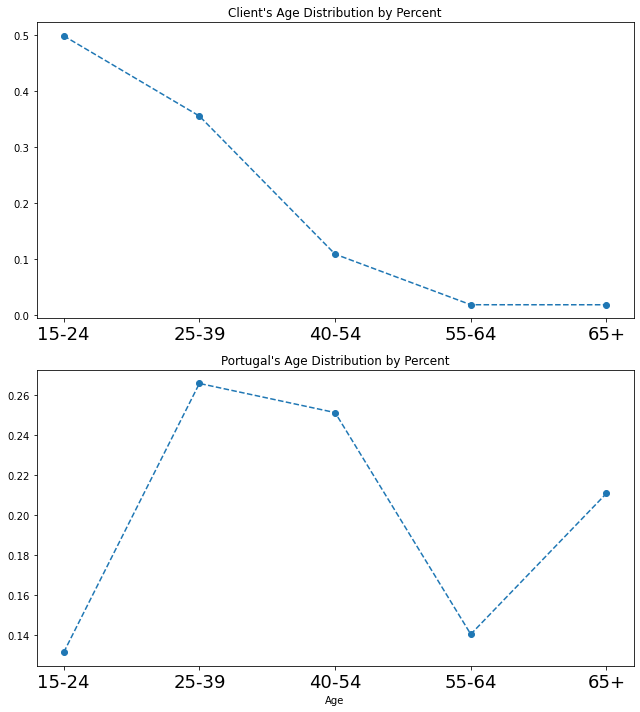

In [35]:
plt.figure(figsize=(9,10))

ax1 = plt.subplot(212)
plt.plot(['15-24', '25-39', '40-54', '55-64', '65+'], port_pop['Percentage'], 'o--')
plt.title("Portugal's Age Distribution by Percent")
plt.tick_params('x', labelsize=18)
plt.xlabel('Age')

ax2 = plt.subplot(211, sharex=ax1)
plt.plot(['15-24', '25-39', '40-54', '55-64', '65+'], client_age['Percentage'], 'o--')
plt.title("Client's Age Distribution by Percent")
plt.tick_params('x', labelsize=18)

#plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

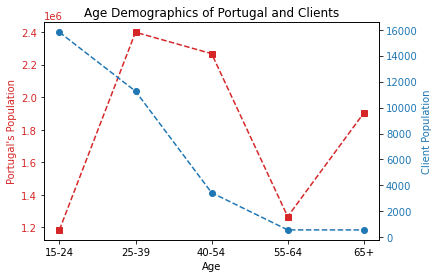

<Figure size 720x720 with 0 Axes>

In [36]:
#import matplotlib.ticker as tk

fig, ax1 = plt.subplots()
plt.figure(figsize=(10,10))

color = 'tab:red'
ax1.plot(['15-24', '25-39', '40-54', '55-64', '65+'], port_pop['Population'], 's--', color = color)
ax1.set_xlabel('Age')
ax1.set_ylabel("Portugal's Population", color=color)
ax1.tick_params('y', labelcolor=color)

ax2 = ax1.twinx() #instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.plot(['15-24', '25-39', '40-54', '55-64', '65+'], client_age['Population'], 'o--', color=color)
ax2.set_ylabel("Client Population", color=color)
ax2.tick_params('y', labelcolor =  color)

title = "Age Demographics of Portugal and Clients"
ax1.set_title(title)
plt.tight_layout()
plt.savefig(p / (title+'.pdf') )
plt.show()

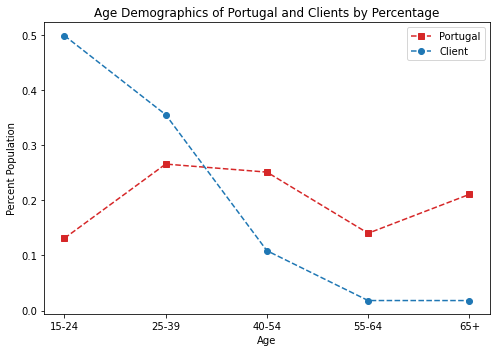

In [37]:
#import matplotlib.ticker as tk

plt.figure(figsize=(7,5))

color = 'tab:red'
plt.plot(['15-24', '25-39', '40-54', '55-64', '65+'], port_pop['Percentage'], 's--', color = color)
plt.xlabel('Age')
plt.ylabel("Percent Population")

#ax2 = ax1.twinx() #instantiate a second axes that shares the same x-axis

color = 'tab:blue'
plt.plot(['15-24', '25-39', '40-54', '55-64', '65+'], client_age['Percentage'], 'o--', color=color)

title = "Age Demographics of Portugal and Clients by Percentage"
plt.title(title)
plt.legend(["Portugal", 'Client'])
plt.tight_layout()
plt.savefig(p / (title+'.pdf') )
plt.show()

## organizing "previous" column into category

In [39]:
previous_cat = []
pre_col = data.previous
for i in pre_col:
    if i < 0.5:
        previous_cat.append('0')
    elif i < 1.5:
        previous_cat.append('1')
    elif i < 2.5:
        previous_cat.append('2')
    elif i < 3.5:
        previous_cat.append('3')        
    elif i < 4.5:
        previous_cat.append('4')
    else:
        previous_cat.append('>4')
        
data_pre = data
data_pre['prev_cat'] = previous_cat
data_pre.head()

data_pre['prev_cat'] = pd.Categorical(data['prev_cat'],
                                   categories=['0', '1', '2', '3', '4', '>4'],
                                   ordered=True)

<AxesSubplot:xlabel='prev_cat', ylabel='count'>

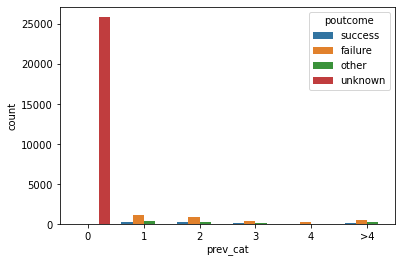

In [40]:
sns.countplot(hue='poutcome', x='prev_cat', data=data_pre)

# Making pie chart for acceptance rate

The Acceptance rate is 11.698%


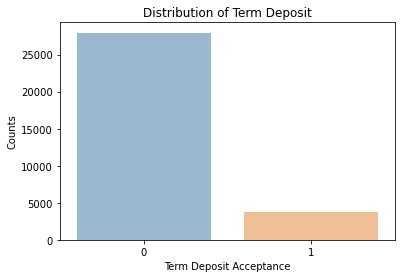

In [41]:
sns.countplot(x='y_bool',data = data, alpha=0.5)
plt.xlabel('Term Deposit Acceptance')
plt.ylabel('Counts')
plt.title('Distribution of Term Deposit');
print('The Acceptance rate is {}%'.format(round(raw_df.y_bool.mean(),5)*100))

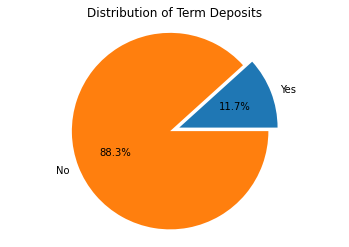

In [42]:
#making a pi chart for the report
acc_rate = round(raw_df.y_bool.mean(), 4)*100
labels = 'Yes', 'No'
sizes = [acc_rate, 100-(acc_rate)]
explode = (0, 0.1)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct = '%1.1f%%', startangle=0)
ax1.axis('equal')

title = "Distribution of Term Deposits"
ax1.set_title(title)
plt.savefig(p / (title+'.pdf') )
plt.show()

# EDA: making charts for the different features vs subscription rate

In [43]:
# initial source: https://github.com/rohanML/home_credit_default_risk/blob/master/notebooks/02_Exploratory_Data_Analysis.ipynb

#To track modified features : 
# eg combine levels with few records into one level called 'Others'

modified_features = dict()

# From Pandas Cookbook 1.X
def flatten_cols(df):
    df.columns = ['_'.join(x) for x in
        df.columns.to_flat_index()]
    return df

# to save plots
p = Path.cwd().parent / 'Portugese Banking Project' / 'reports' / 'figures'
suffix ='.pdf'


# To plot categorical featues.
# We plot categories on x-axis, default rate on primary y-axis & number of observations on secondary y axis.
# Plotting number of observations indicated the credibility of default rate.
def plot_default_cat_feat(df, var, var_desc, sort_by = None):
    """
    Plot default rate for different categories in the feature
    
    Keyword arguments:
    df -- DataFrame
    var -- categorical feature to be grouped by
    var_desc -- description of the feature to be displayed as label 
    sort_by -- specifies how the aggregated dataframe is sorted.  If it is
                'default_rate' -- categories are sorted by default rate in ascending order
                'count' -- categories are sorted by record counts in descending order
                None -- no sorting is done
    
    Missing values are represented by 'Missing' level.
    """

    with plt.style.context('bmh'):
        # aggregate the data
        df_grouped = df.groupby(var,dropna=False).agg({'y_bool':['mean'],'cust_id':['count']}).pipe(flatten_cols)
        df_grouped.index = df_grouped.index.fillna('Missing')

        # sorting
        if sort_by == 'count':
            df_grouped.sort_values(by='cust_id_count',ascending=False,inplace=True)
        elif sort_by == 'default_rate':
            df_grouped.sort_values(by='y_bool_mean',ascending=True,inplace=True)
        
        # plotting default rate on primary y-axis
        fig, ax = plt.subplots()
        # plt.rcParams['figure.dpi']= 480
        fontsize = 15
        # Increase the size of graph when we have more than 4 categories
        if df_grouped.shape[0] > 4:
            fig.set_size_inches(9,6)
            fontsize = 12
            plt.xticks(rotation=45, ha='right')
        ax.plot(df_grouped.index, df_grouped.y_bool_mean, 'o--', color= 'red',alpha=0.6)
        # Add value labels for dafault rates
        #source : https://stackoverflow.com/questions/59143306/add-label-values-to-bar-chart-and-line-chart-in-matplotlib
        line = ax.lines[0]
        for x_value, y_value in zip(line.get_xdata(), line.get_ydata()):
            label = "{:.1%}".format(y_value)
            ax.annotate(label,(x_value, y_value), xytext=(0, 5), textcoords="offset points",
                        fontsize=fontsize,color = 'red',ha='center', va='bottom') 
            
        ax.set_title('Term Loan Subscription Rate by '+var_desc)
        ax.set_ylabel('Subscription Rate')
        ax.set_xlabel(var_desc)
        ax.set_facecolor('lavenderblush') #background color
        
        # setting the y-axis limit
        ax.set_ylim(ymin=0,ymax=df_grouped.y_bool_mean.max()+0.05)
        ax.yaxis.set_major_formatter(PercentFormatter(1))
        
        # plotting count of records on secondary y-axis
        ax2 = plt.twinx()
        ax2.bar(df_grouped.index,df_grouped.cust_id_count,
                    alpha=0.3, color='sandybrown')
        ax2.set_ylabel('Counts')
        ax2.grid(False)
        
        # Add legends for both y axes
        # source: https://stackoverflow.com/questions/5484922/secondary-axis-with-twinx-how-to-add-to-legend
        # https://mpltest2.readthedocs.io/en/stable/gallery/recipes/transparent_legends.html
        fig.legend(labels=('Subscription Rate','Counts'),loc='upper right',bbox_to_anchor=(1,1),
                   bbox_transform=ax.transAxes,fancybox=True, framealpha=0.2)
        sns.despine(left=True,bottom=True,)
        plt.tight_layout()
        plt.savefig(p / (var_desc+'.pdf') )
        plt.show();
      
    
# To plot continuous features. We first convert continuous feature into suitable bins.
# Then we plot bins on x-axis, default rate on primary y-axis & number of observations on secondary y axis.
# Plotting number of observations indicated the credibility of default rate.


def plot_default_cont_feat(df, var, var_desc, n = 10, pct_range = (0.0,1.0), decimals = 0 ):
    """
    Plot default rate for continuous feature. We bin continuous feature & then plot default rate & count of observation.
    
    Keyword arguments:
    df -- DataFrame
    var -- categorical feature to be grouped by
    var_desc -- description of the feature to be displayed as label 
    n -- number of bins
    pct_range -- percentile range used for plotting. Values outside this range will be excluded.
    decimals -- to tune number of bins. eg if a feature has [0,1] range, then decimal is 
                atleast 2 to avoid duplicate bins.
                
    """
    df_temp = df[[var,'y_bool','cust_id']].copy()
    l_pct = pct_range[0]
    u_pct = pct_range[1]
    f_min = df_temp[var].quantile(l_pct) - 1/(10**decimals) # 0.01 added to that lower value is not excluded
    f_max = df_temp[var].quantile(u_pct) + 1/(10**decimals)
    mod_var = 'mod'+'_'+ var
    intvl = pd.interval_range(start=f_min, end= f_max, periods= n)
    # Round lower and upper limits of interval
    intvl = pd.IntervalIndex([ pd.Interval( round(i.left,decimals), 
                                round(i.right,decimals), i.closed ) for i in intvl ])
    df_temp.loc[:,mod_var]= pd.cut(df_temp[var],intvl)
    print('Count of missing observations : {}'.format(df_temp.loc[:,var].isna().sum()))
    excluded_obs = df_temp.loc[:,mod_var].isna().sum() - df_temp.loc[:,var].isna().sum()
    print('Count of excluded observations: {}'.format(excluded_obs))
    df_grouped = df_temp.groupby(mod_var,dropna=False).agg({'y_bool':['mean'],'cust_id':['count']}).pipe(flatten_cols)
    del df_temp  
    with plt.style.context('bmh'):
        # plotting default rate on primary y-axis
        fig, ax = plt.subplots()
        fig.set_size_inches(9,6)
        
        plt.xticks(rotation=45, ha='right')
        ax.plot(df_grouped.index.astype('str'), df_grouped.y_bool_mean, 'o--', color= 'red',alpha=0.6)
        ax.set_title('Term Loan Subscription Rate by '+var_desc)
        ax.set_ylabel('Subscription Rate')
        ax.set_xlabel(var_desc)
        ax.set_facecolor('lavenderblush') #background color
        
        # setting the y-axis limit
        ax.set_ylim(ymin=0,ymax=df_grouped.y_bool_mean.max()+0.05)
        ax.yaxis.set_major_formatter(PercentFormatter(1))
        line = ax.lines[0]
        for x_value, y_value in zip(line.get_xdata(), line.get_ydata()):
            label = "{:.1%}".format(y_value)
            ax.annotate(label,(x_value, y_value), xytext=(5, 5), textcoords="offset points",
                        fontsize=10,color = 'red',ha='center', va='bottom') 
        
        # plotting count of records on secondary y-axis
        ax2 = plt.twinx()
        ax2.bar(df_grouped.index.astype('str'),df_grouped.cust_id_count,
                    alpha=0.3, color='sandybrown')
        ax2.set_ylabel('Counts')
        ax2.grid(False)
        
        # Add legends for both y axes
        # source: https://stackoverflow.com/questions/5484922/secondary-axis-with-twinx-how-to-add-to-legend
        # https://mpltest2.readthedocs.io/en/stable/gallery/recipes/transparent_legends.html
        fig.legend(labels=('Subscription Rate','Counts'),loc='upper right',bbox_to_anchor=(1,1),
                   bbox_transform=ax.transAxes,fancybox=True, framealpha=0.2)
        sns.despine(left=True,bottom=True,)
        plt.tight_layout()
        plt.savefig(p / (var_desc+'.pdf') )
        plt.show();
        

def sturge(N):
    
    """Finds the number of bins for a histogram based on Sturge's Rule.
    
    Keyword Arguments:
    N -- the number of samples in the set
    
    """
    K = 1 + 3.322* math.log(N, 10)
    return int(round(K,0))

bins = sturge(len(data))

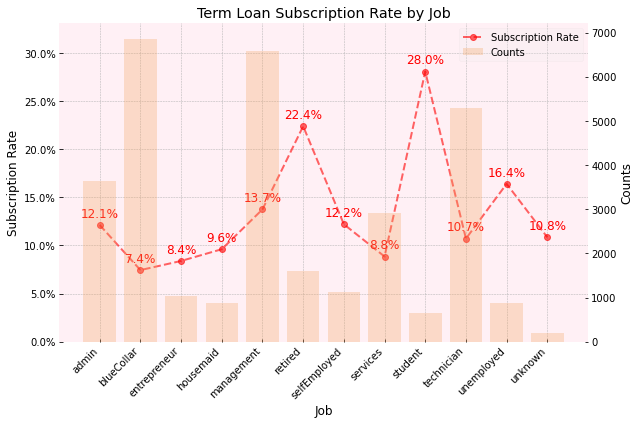

In [44]:
plot_default_cat_feat(data, 'job', 'Job')

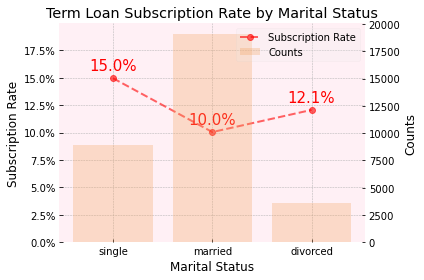

In [45]:
plot_default_cat_feat(data, 'marital', 'Marital Status')

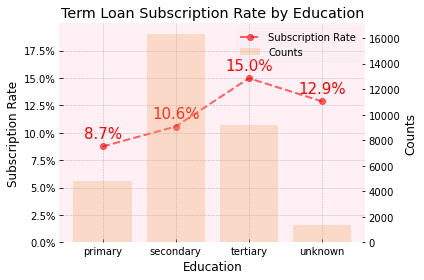

In [46]:
plot_default_cat_feat(data, 'education', 'Education')

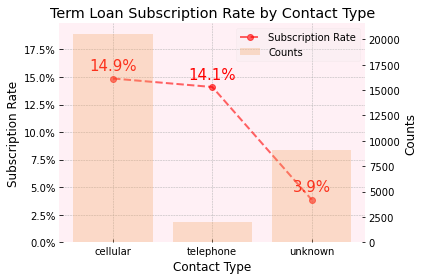

In [47]:
plot_default_cat_feat(data, 'contact', 'Contact Type')

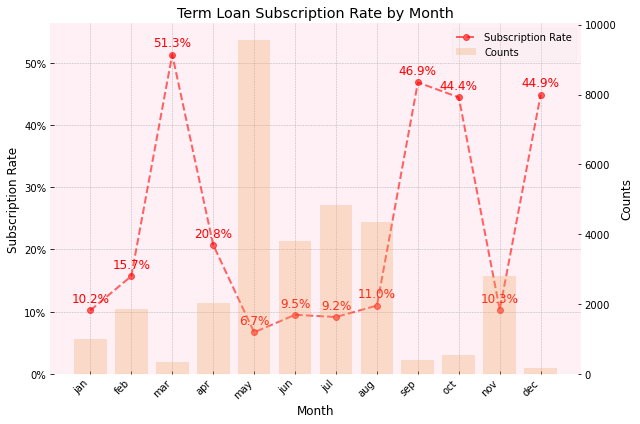

In [48]:
plot_default_cat_feat(data, 'month', 'Month')

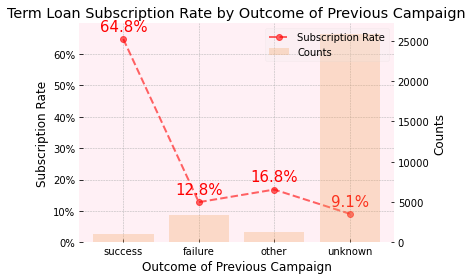

In [49]:
plot_default_cat_feat(data, 'poutcome', 'Outcome of Previous Campaign')

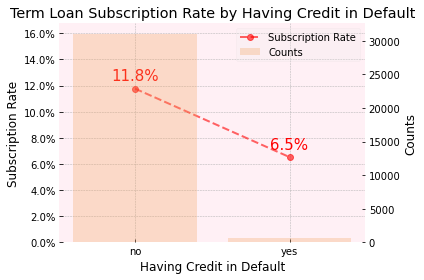

In [50]:
plot_default_cat_feat(data, 'default', 'Having Credit in Default')

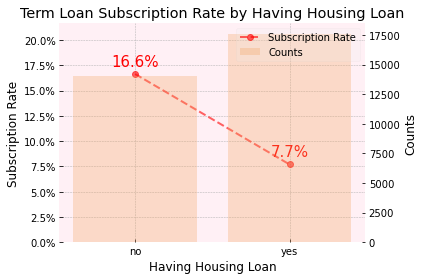

In [51]:
plot_default_cat_feat(data, 'housing', 'Having Housing Loan')

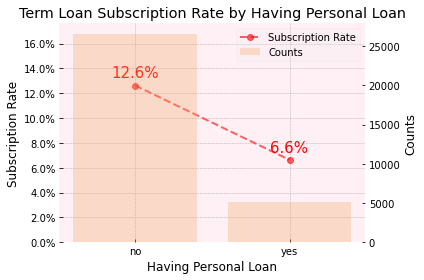

In [52]:
plot_default_cat_feat(data, 'loan', 'Having Personal Loan')

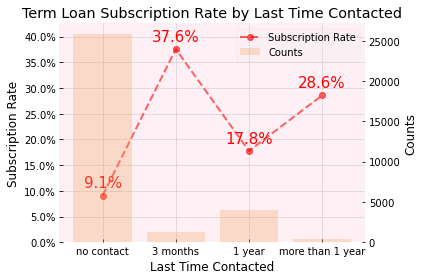

In [53]:
plot_default_cat_feat(data, 'pdays_cat', 'Last Time Contacted')

Count of missing observations : 0
Count of excluded observations: 0


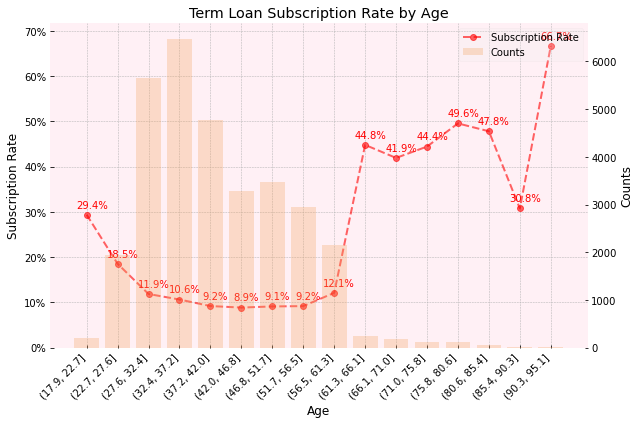

In [54]:
plot_default_cont_feat(data, 'age', "Age", n = bins, pct_range = (0.0,1.0), decimals = 1)

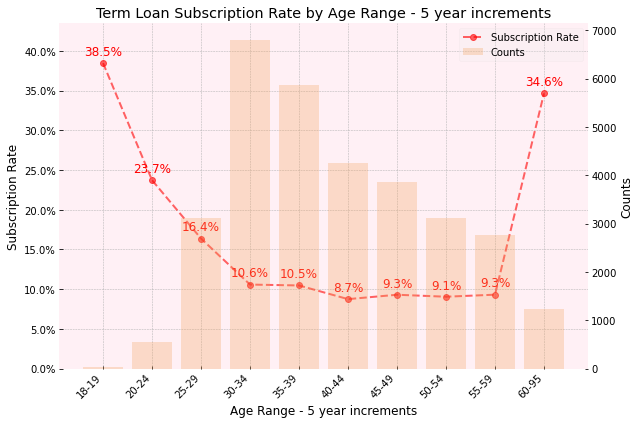

In [55]:
plot_default_cat_feat(data_age, 'age_cat', 'Age Range - 5 year increments')

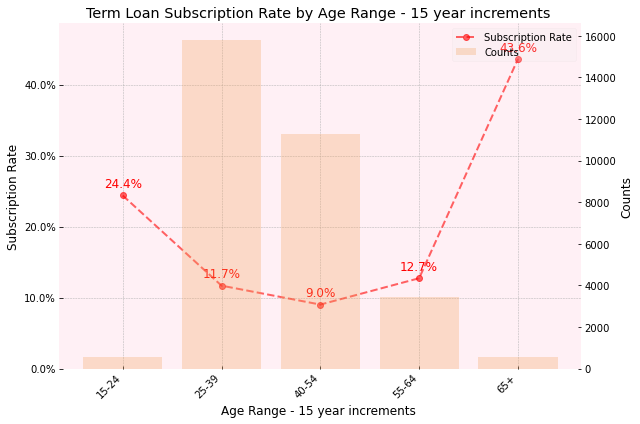

In [56]:
plot_default_cat_feat(data_age, 'age_pop', 'Age Range - 15 year increments ')

Count of missing observations : 0
Count of excluded observations: 0


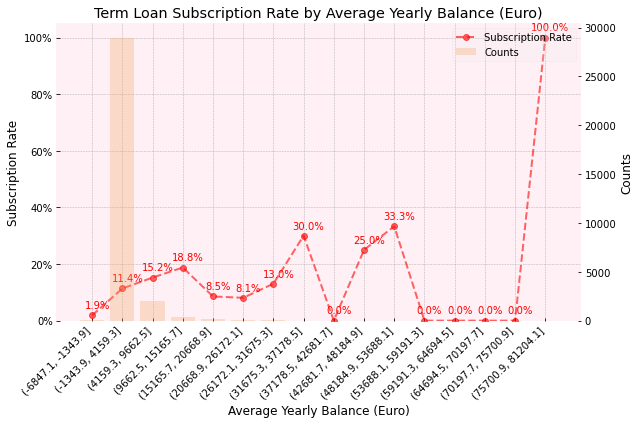

In [57]:
plot_default_cont_feat(data, 'balance', "Average Yearly Balance (Euro)", n = bins, pct_range = (0.0,1.0), decimals = 1)

Count of missing observations : 0
Count of excluded observations: 0


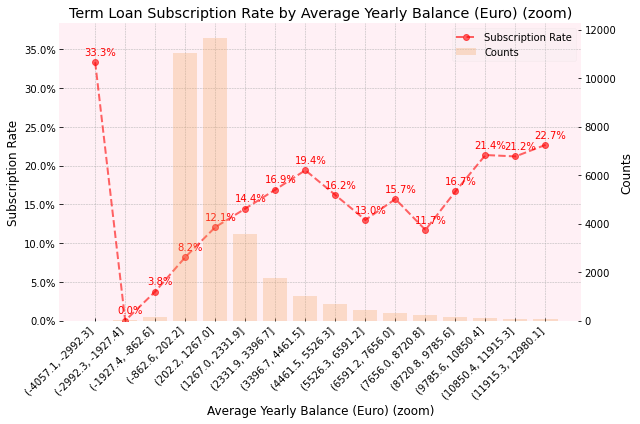

In [58]:
plot_default_cont_feat(data_bal, 'balance', "Average Yearly Balance (Euro) (zoom)", n = bins, pct_range = (0.0,1.0), decimals = 1)

Count of missing observations : 0
Count of excluded observations: 0


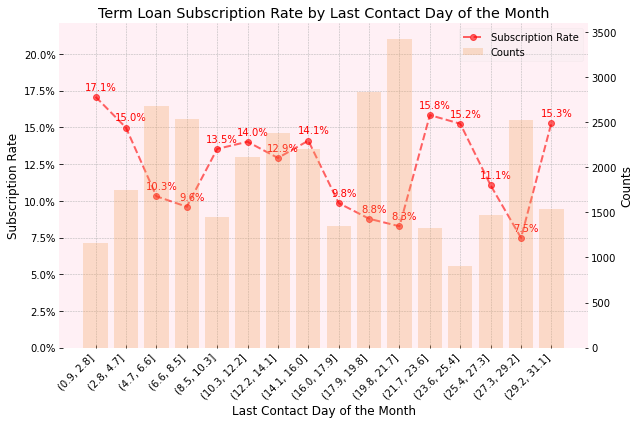

In [59]:
plot_default_cont_feat(data, 'day', "Last Contact Day of the Month", n = bins, pct_range = (0.0,1.0), decimals = 1)

Count of missing observations : 0
Count of excluded observations: 0


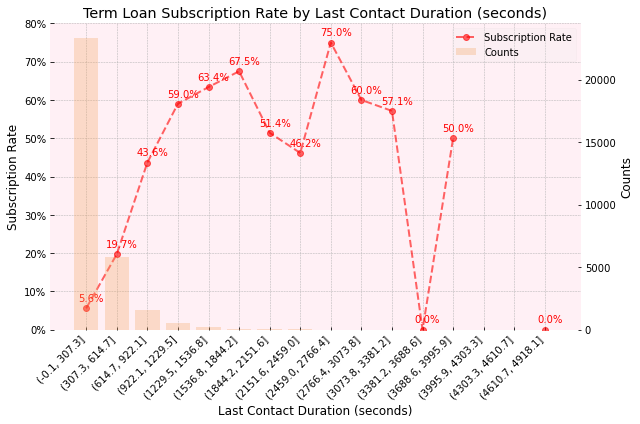

In [60]:
plot_default_cont_feat(data, 'duration', "Last Contact Duration (seconds)", n = bins, pct_range = (0.0,1.0), decimals = 1)

Count of missing observations : 0
Count of excluded observations: 0


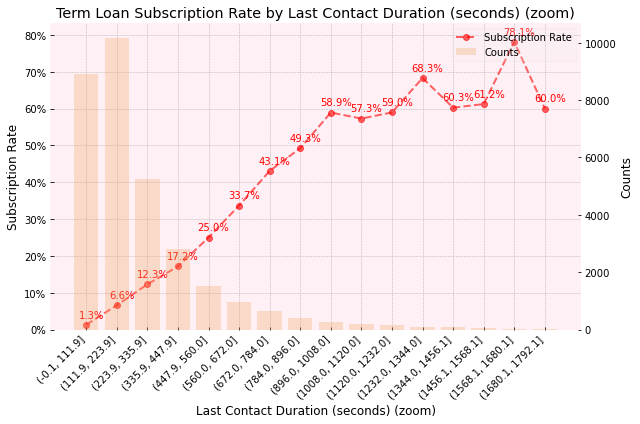

In [61]:
plot_default_cont_feat(data_dur, 'duration', "Last Contact Duration (seconds) (zoom)", n = bins, pct_range = (0.0,1.0), decimals = 1)

Count of missing observations : 0
Count of excluded observations: 0


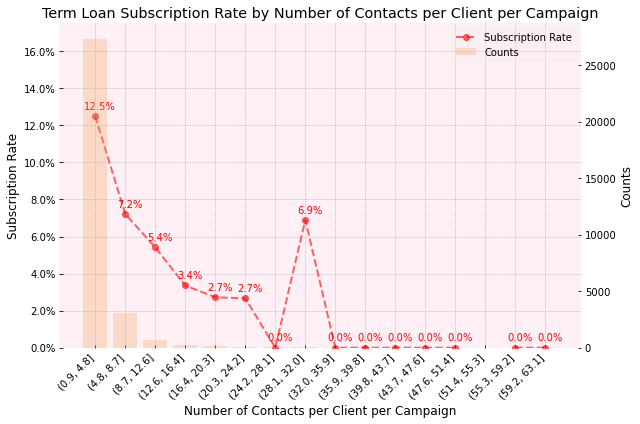

In [62]:
plot_default_cont_feat(data, 'campaign', "Number of Contacts per Client per Campaign", n = bins, pct_range = (0.0,1.0), decimals = 1)

Count of missing observations : 0
Count of excluded observations: 0


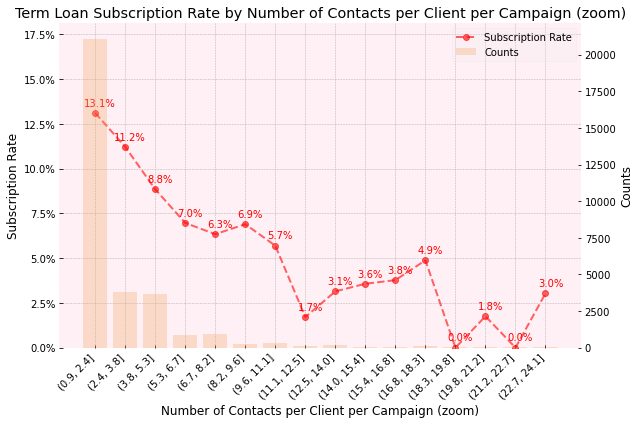

In [63]:
plot_default_cont_feat(data_cam, 'campaign', "Number of Contacts per Client per Campaign (zoom)", n = bins, pct_range = (0.0,1.0), decimals = 1)

Count of missing observations : 0
Count of excluded observations: 0


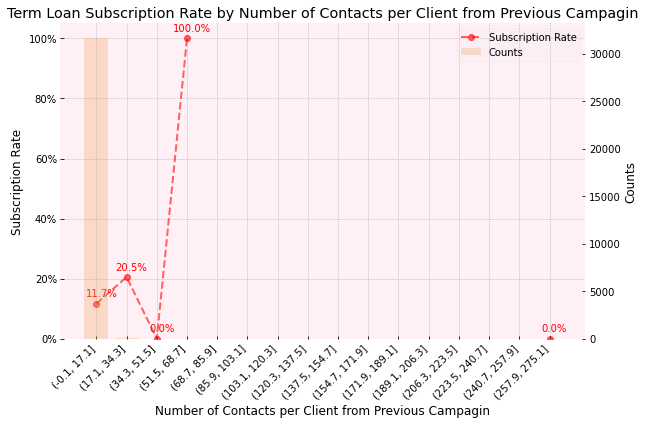

In [64]:
plot_default_cont_feat(data, 'previous', "Number of Contacts per Client from Previous Campagin", n = bins, pct_range = (0.0,1.0), decimals = 1)

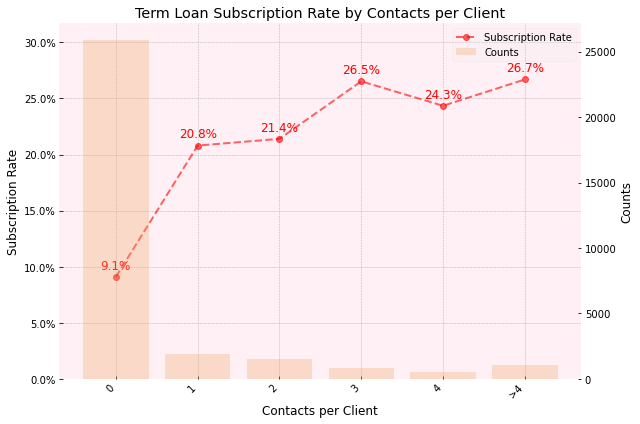

In [65]:
plot_default_cat_feat(data_pre, 'prev_cat', 'Contacts per Client')

# Heat map

In [66]:
# original source: https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

#this function is used for correlation between multi-level categorical features (non-binomial) and numerical features
# extracted from https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
def correlation_ratio(categories, measurements):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0,cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator/denominator)
    return eta

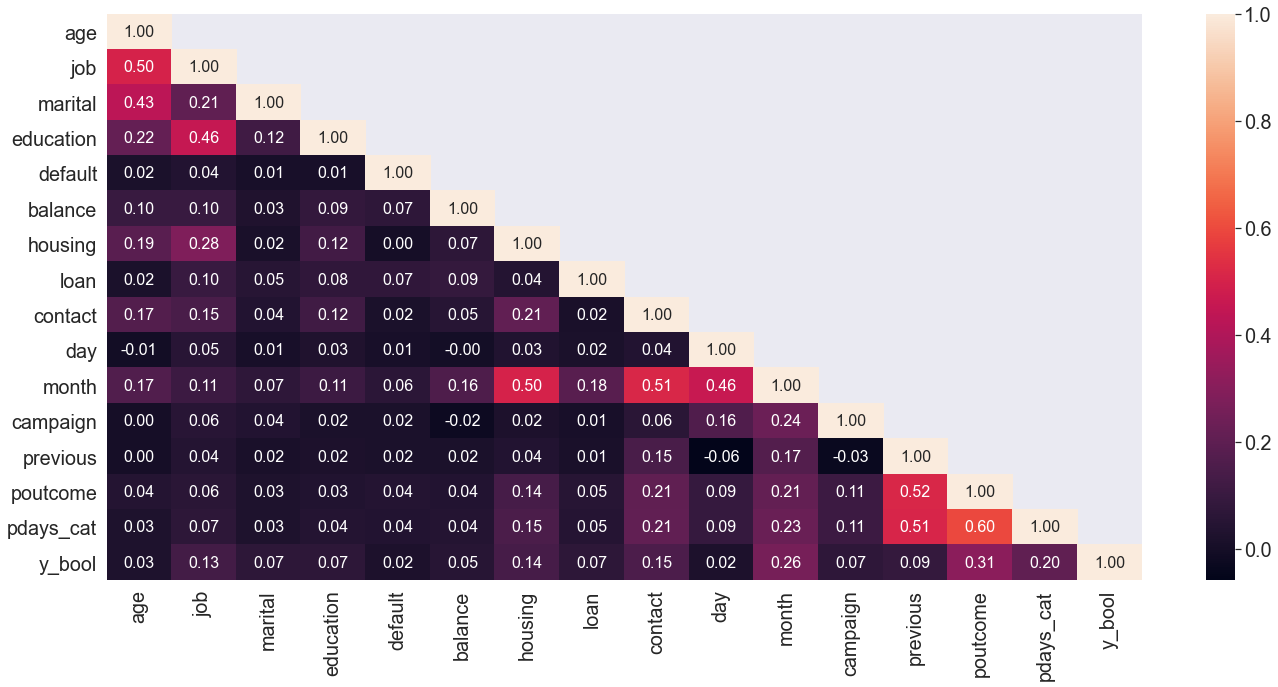

In [67]:
# initial source: https://github.com/ithisted/PetAdoptionPrediction/blob/master/PetAdoptionPrediction.ipynb

columns = data.columns
columns = columns.drop(['cust_id', 'age_cat', 'prev_cat', 'duration', 'age_pop'])
corr = pd.DataFrame(index=columns, columns=columns)

for i in range(0, len(columns)):
    for j in range(i, len(columns)):
        
            if i == j:
                corr_factor = 1.0
            
            elif (columns[i] in cat_col) and (columns[j] in cat_col):
                corr_factor =  cramers_v(data[columns[j]], data[columns[i]])
            
            elif (columns[i] in num_col) and (columns[j] in num_col):
                corr_factor, pvalue = ss.pearsonr(data[columns[j]], data[columns[i]])
                #if pvalue > 0.05:
                    #corr_factor = np.nan
            
            elif (columns[i] in num_col) and (columns[j] in cat_col):
                corr_factor =  correlation_ratio(data[columns[j]], data[columns[i]])
                
            elif (columns[i] in cat_col) and (columns[j] in num_col):
                corr_factor =  correlation_ratio(data[columns[i]], data[columns[j]])
                           
                #if pvalue > 0.05:
                    #corr_factor = np.nan
                
            corr.loc[columns[j],columns[i]] = corr_factor
    
corr.fillna(value=np.nan,inplace=True)
plt.figure(figsize=(20,10))
sns.set(font_scale=1.8) 
sns.heatmap(corr,annot=True,fmt='.2f',annot_kws={"size": 16})
plt.tight_layout()
plt.savefig(p / ('heatmap.pdf') )
plt.show()    


In [68]:
num_col = ['age', "balance", 'day', 'duration', 'campaign', 'previous']
cat_col = ['job', 'marital', 'education', 'contact', 'month', 'poutcome', 'default', 'housing', 'loan', 'pdays_cat', 'y_bool']
features = ['age', "balance", 'day', 'campaign', 'previous', 'job', 'marital', 'education', 'contact', 'month', 'poutcome', 'default', 'housing', 'loan', 'pdays_cat', 'random']

# Feature Importance

In [69]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

#Splitting target and features

df_train['random'] = np.random.random(size = df_train.shape[0]) #adding a random column for a baseline on feature importances
X = df_train[features]
y = df_train['y_bool']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)


In [70]:
#https://towardsdatascience.com/my-random-forest-classifier-cheat-sheet-in-python-fedb84f8cf4f

features_to_encode = X_train.columns[X_train.dtypes==object].tolist()  

In [71]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
col_trans = make_column_transformer(
                        (OneHotEncoder(),features_to_encode),
                        remainder = "passthrough"
                        )

In [72]:
rf_classifier = RandomForestClassifier(
                      min_samples_leaf=50,
                      n_estimators=150,
                      bootstrap=True,
                      oob_score=True,
                      n_jobs=-1,
                      random_state=42,
                      max_features='auto')

In [73]:
X_train

,age,balance,day,campaign,previous,job,marital,education,contact,month,poutcome,default,housing,loan,pdays_cat,random
4335,57,894,18,1,0,selfEmployed,married,tertiary,cellular,nov,unknown,no,yes,no,no contact,0.552454
29171,32,656,20,2,0,management,single,tertiary,cellular,apr,unknown,no,yes,yes,no contact,0.610279
16793,52,199,12,2,0,entrepreneur,divorced,tertiary,unknown,jun,unknown,no,yes,yes,no contact,0.530999
14077,33,0,11,7,0,management,single,tertiary,cellular,aug,unknown,no,no,no,no contact,0.150437
4550,46,245,8,1,3,entrepreneur,married,secondary,cellular,may,failure,no,yes,no,1 year,0.438275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29802,44,1277,17,1,4,management,single,tertiary,cellular,apr,other,no,yes,no,1 year,0.739197
5390,45,2048,18,1,1,management,single,tertiary,cellular,oct,failure,no,yes,no,more than 1 year,0.504857
860,37,-76,28,1,1,management,married,tertiary,cellular,jan,other,no,yes,no,1 year,0.742263
15795,41,402,17,17,0,blueCollar,married,primary,unknown,jun,unknown,no,no,no,no contact,0.139297


In [74]:
y_train

4335     0
29171    0
16793    0
14077    1
4550     0
        ..
29802    0
5390     1
860      0
15795    0
23654    0
Name: y_bool, Length: 23735, dtype: int64

In [75]:
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(col_trans, rf_classifier)
pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['job', 'marital',
                                                   'education', 'contact',
                                                   'month', 'poutcome',
                                                   'default', 'housing', 'loan',
                                                   'pdays_cat'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(min_samples_leaf=50, n_estimators=150,
                                        n_jobs=-1, oob_score=True,
                                        random_state=42))])

In [76]:
y_pred = pipe.predict(X_test)

In [77]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, f1_score

accuracy_score(y_test, y_pred)
print(f"The accuracy of the model is {round(accuracy_score(y_test,y_pred),4)*100} %")

The accuracy of the model is 89.59 %


In [78]:
train_probs = pipe.predict_proba(X_train)[:,1] 
probs = pipe.predict_proba(X_test)[:, 1]
train_predictions = pipe.predict(X_train)

In [79]:
print(f'Train ROC AUC Score: {roc_auc_score(y_train, train_probs)}')
print(f'Test ROC AUC  Score: {roc_auc_score(y_test, probs)}')

Train ROC AUC Score: 0.8269535622763999
Test ROC AUC  Score: 0.7940512450049594


Recall
            Baseline: 1.0
            Test: 0.15
            Train: 0.15
Precision
            Baseline: 0.11
            Test: 0.68
            Train: 0.72
Roc
            Baseline: 0.5
            Test: 0.79
            Train: 0.83


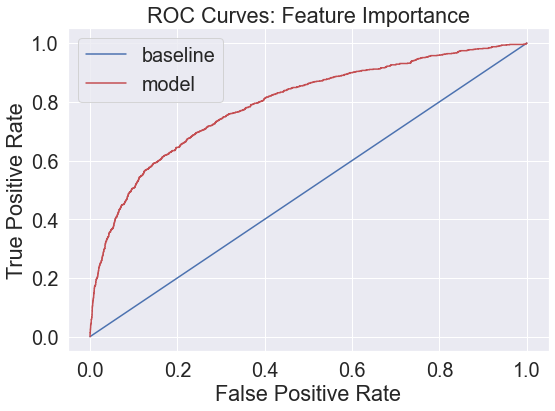

In [125]:
def evaluate_model(y_pred, probs,train_predictions, train_probs, title_name):
    baseline = {}
    baseline['recall']=recall_score(y_test,
                    [1 for _ in range(len(y_test))])
    baseline['precision'] = precision_score(y_test,
                    [1 for _ in range(len(y_test))])
    baseline['roc'] = 0.5
    results = {}
    results['recall'] = recall_score(y_test, y_pred)
    results['precision'] = precision_score(y_test, y_pred)
    results['roc'] = roc_auc_score(y_test, probs)
    train_results = {}
    train_results['recall'] = recall_score(y_train, train_predictions)
    train_results['precision'] = precision_score(y_train, train_predictions)
    train_results['roc'] = roc_auc_score(y_train, train_probs)
    for metric in ['recall', 'precision', 'roc']:  
        print(f'''{metric.capitalize()}
            Baseline: {round(baseline[metric], 2)}
            Test: {round(results[metric], 2)}
            Train: {round(train_results[metric], 2)}''')
            
     # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
    model_fpr, model_tpr, _ = roc_curve(y_test, probs)
    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate');
    plt.ylabel('True Positive Rate'); plt.title('ROC Curves: '+ title_name);
    plt.tight_layout()
    plt.savefig(p / (title +'.pdf') )
    plt.show();

evaluate_model(y_pred,probs,train_predictions,train_probs, title_name="Feature Importance")

In [81]:
confusion_matrix(y_test, y_pred, normalize='all')

array([[0.87917088, 0.00796259],
       [0.09618301, 0.01668352]])

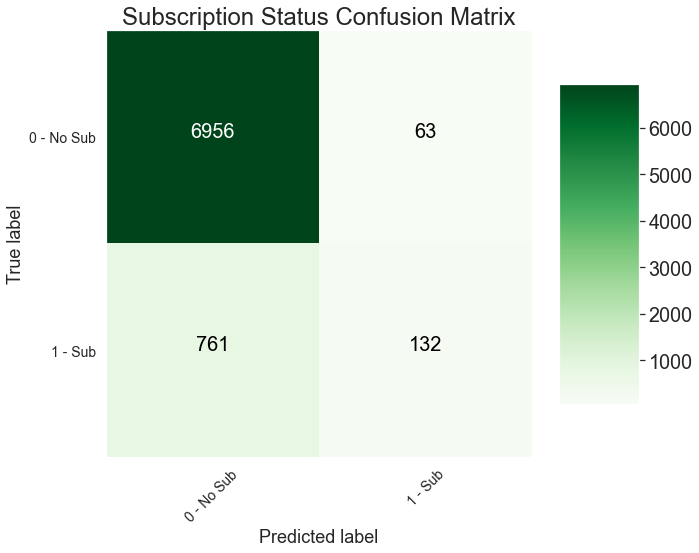

In [118]:
import itertools
def plot_confusion_matrix(cm, classes, normalize = False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens): # can change color 
    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    # Label the plot
    for i, j in itertools.product(range(cm.shape[0]),   range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), 
             fontsize = 20,
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)
    plt.tight_layout()
    plt.savefig(p / (title+'.pdf') )
    
# Let's plot
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes = ['0 - No Sub', '1 - Sub'],
                      title = 'Subscription Status Confusion Matrix')

Random Forest Feature Importance

In [83]:
print(rf_classifier.feature_importances_)
print(f" There are {len(rf_classifier.feature_importances_)} features in total")

[1.02260965e-03 3.09958048e-03 1.05441846e-04 1.68588354e-04
 2.23981105e-03 3.45596371e-03 1.87579061e-04 6.40029241e-04
 5.13644072e-03 1.65266397e-03 3.06879932e-04 0.00000000e+00
 1.42310977e-03 7.45972791e-03 7.15083309e-03 1.50050389e-03
 3.49374560e-03 7.39717514e-03 2.44832230e-04 2.32847072e-02
 1.88913790e-03 4.00252232e-02 3.00555991e-02 1.12305676e-02
 4.44688018e-04 2.35504165e-03 2.15040404e-03 7.00940968e-03
 1.25492964e-02 2.54828587e-02 1.08696158e-02 5.83699891e-03
 2.04478226e-02 2.03234026e-02 2.94120633e-02 1.13707192e-02
 2.36399967e-01 2.50869764e-02 7.43624232e-05 7.99144551e-05
 4.51169173e-02 4.38676246e-02 4.68802162e-03 6.37497645e-03
 9.55388906e-03 4.36068753e-02 1.58403720e-03 3.86041350e-02
 9.69805203e-02 3.90490358e-02 3.04000985e-02 1.75455141e-02
 3.89008760e-02 2.06631871e-02]
 There are 54 features in total


In [84]:
# Let's look at the first row
print(col_trans.fit_transform(X_train)[0,:])

  (0, 6)	1.0
  (0, 13)	1.0
  (0, 17)	1.0
  (0, 19)	1.0
  (0, 31)	1.0
  (0, 37)	1.0
  (0, 38)	1.0
  (0, 41)	1.0
  (0, 42)	1.0
  (0, 47)	1.0
  (0, 48)	57.0
  (0, 49)	894.0
  (0, 50)	18.0
  (0, 51)	1.0
  (0, 53)	0.5524541348280727


In [85]:
# And the first row of X_train
X_train.iloc[0,:]  

age                    57
balance               894
day                    18
campaign                1
previous                0
job          selfEmployed
marital           married
education        tertiary
contact          cellular
month                 nov
poutcome          unknown
default                no
housing               yes
loan                   no
pdays_cat      no contact
random           0.552454
Name: 4335, dtype: object

In [86]:
def encode_and_bind(original_dataframe, features_to_encode):
    dummies = pd.get_dummies(original_dataframe[features_to_encode])
    res = pd.concat([dummies, original_dataframe], axis=1)
    res = res.drop(features_to_encode, axis=1)
    return(res)
X_train_encoded = encode_and_bind(X_train, features_to_encode)

In [87]:
feature_importances = list(zip(X_train_encoded, rf_classifier.feature_importances_))
# Then sort the feature importances by most important first
feature_importances_ranked = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances
[print('Feature: {:35} Importance: {}'.format(*pair)) for pair in feature_importances_ranked];

Feature: poutcome_success                    Importance: 0.23639996695810903
Feature: age                                 Importance: 0.09698052026086847
Feature: housing_no                          Importance: 0.04511691725349581
Feature: housing_yes                         Importance: 0.04386762459300462
Feature: pdays_cat_3 months                  Importance: 0.04360687529043301
Feature: contact_unknown                     Importance: 0.04002522317372631
Feature: balance                             Importance: 0.03904903578701736
Feature: previous                            Importance: 0.03890087604979509
Feature: pdays_cat_no contact                Importance: 0.03860413501231418
Feature: day                                 Importance: 0.030400098532568833
Feature: month_apr                           Importance: 0.03005559907874364
Feature: poutcome_failure                    Importance: 0.029412063257839016
Feature: month_mar                           Importance: 0.025482858667274

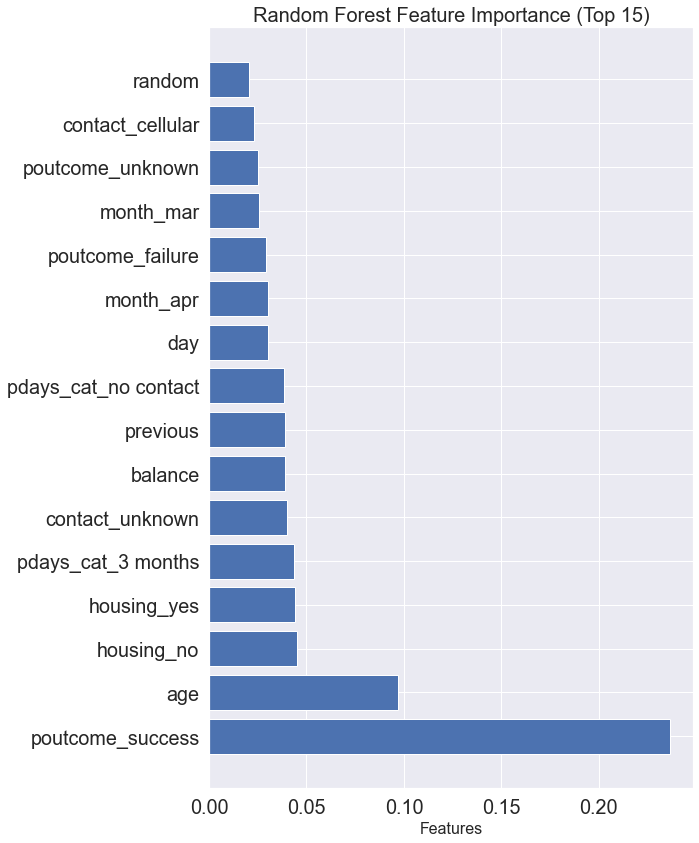

In [88]:
# Plot the top 25 feature importance
feature_names_25 = [i[0] for i in feature_importances_ranked[:16]]
y_ticks = np.arange(0, len(feature_names_25))
x_axis = [i[1] for i in feature_importances_ranked[:16]]
plt.figure(figsize = (10, 12))
plt.barh(feature_names_25, x_axis)   #horizontal barplot
plt.title('Random Forest Feature Importance (Top 15)',
          fontdict= {'fontsize' : 20})
plt.xlabel('Features',fontdict= {'fontsize' : 16})
plt.tight_layout()
plt.savefig(p / ('Random Forest Feature Importance.pdf') )
plt.show()

# Model Selection

In [89]:
from pprint import pprint
print('Parameters currently in use:\n')
pprint(rf_classifier.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 50,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 150,
 'n_jobs': -1,
 'oob_score': True,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [90]:
from sklearn.model_selection import GridSearchCV
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 3)]
max_features = ['auto', 'log2']  # Number of features to consider at every split
max_depth = [int(x) for x in np.linspace(10, 100, num = 3)]   # Maximum number of levels in tree
max_depth.append(None)
min_samples_split = [2, 5, 10]  # Minimum number of samples required to split a node
min_samples_leaf = [1, 4, 10]    # Minimum number of samples required at each leaf node
bootstrap = [True]       # Method of selecting samples for training each tree
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_leaf_nodes': [None] + list(np.linspace(10, 50, 3).astype(int)),
               'n_jobs' : [8], 
               'bootstrap': bootstrap}

In [91]:
# Evaluate Random Forest Model
# Create base model to tune
rf = RandomForestClassifier(oob_score=True)

pprint(rf.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': True,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [92]:
# Create random search model and fit the data
rf_grid = GridSearchCV(
                        estimator = rf,
                        param_grid = random_grid,
                        cv = 3,
                        verbose=1, 
                        scoring='roc_auc')
rf_grid.fit(X_train_encoded, y_train)
rf_grid.best_params_
rf_grid.best_params_

Fitting 3 folds for each of 864 candidates, totalling 2592 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2592 out of 2592 | elapsed: 67.2min finished


{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 500,
 'n_jobs': 8}

In [93]:
# Use the best model after tuning
best_rf_model = rf_grid.best_estimator_
pipe_best_rf_model = make_pipeline(col_trans, best_rf_model)
pipe_best_rf_model.fit(X_train, y_train)
y_pred_best_rf_model = pipe_best_rf_model.predict(X_test)
pprint(best_rf_model.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_jobs': 8,
 'oob_score': True,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [94]:
# To look at nodes and depths of trees use on average
n_nodes = []
max_depths = []
for ind_tree in best_rf_model.estimators_:
       n_nodes.append(ind_tree.tree_.node_count)
       max_depths.append(ind_tree.tree_.max_depth)
print(f'Average number of nodes {int(np.mean(n_nodes))}')   
print(f'Average maximum depth {int(np.mean(max_depths))}') 

Average number of nodes 504
Average maximum depth 10


Recall
            Baseline: 1.0
            Test: 0.17
            Train: 0.2
Precision
            Baseline: 0.11
            Test: 0.68
            Train: 0.82
Roc
            Baseline: 0.5
            Test: 0.8
            Train: 0.84


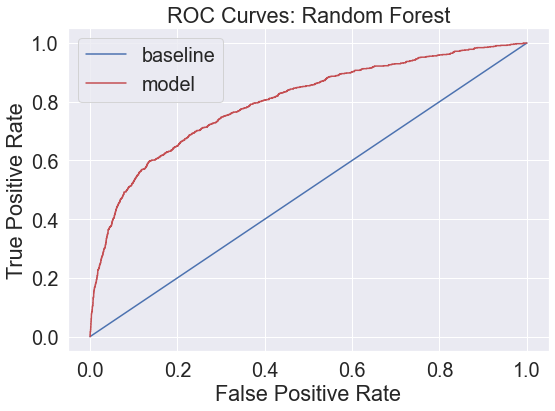

In [126]:
train_rf_predictions = pipe_best_rf_model.predict(X_train)
train_rf_probs = pipe_best_rf_model.predict_proba(X_train)[:, 1]
rf_probs = pipe_best_rf_model.predict_proba(X_test)[:, 1]
# Plot ROC curve and check scores
evaluate_model(y_pred_best_rf_model, rf_probs, train_rf_predictions, train_rf_probs,title_name="Random Forest")

In [96]:
print(f'Train ROC AUC Score: {roc_auc_score(y_train, train_rf_probs)}')
print(f'Test ROC AUC  Score: {roc_auc_score(y_test, rf_probs)}')

Train ROC AUC Score: 0.8446401015907247
Test ROC AUC  Score: 0.7978724201962136


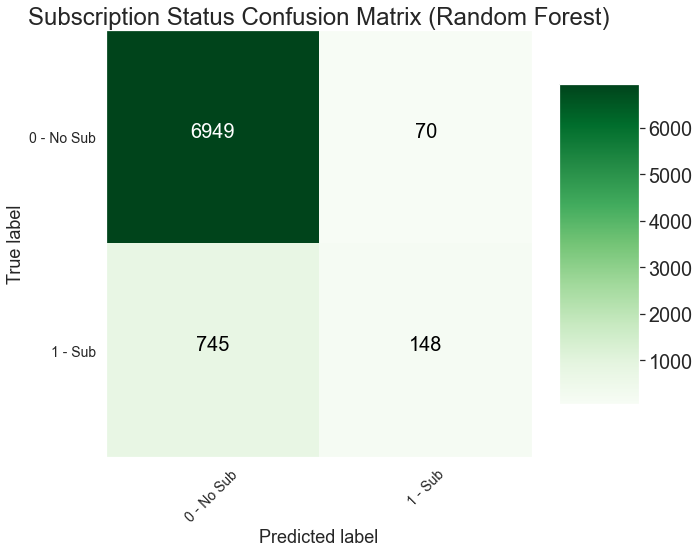

In [115]:
# Plot Confusion matrix
plot_confusion_matrix(confusion_matrix(y_test, y_pred_best_rf_model), classes = ['0 - No Sub', '1 - Sub'],
                      title = 'Subscription Status Confusion Matrix (Random Forest)')

In [98]:
#Testing Logistic Regression Model
#Using source: https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8
from sklearn.linear_model import LogisticRegression

In [99]:
#same as above but using Logistic Regression

# Create base model to tune
lr = LogisticRegression()

pprint(lr.get_params())

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}


In [100]:
from sklearn.model_selection import GridSearchCV
penalty = ['l1', 'l2']
C = np.logspace(-4, 4, 50)
solver = ['liblinear']

grid_lr = {'penalty': penalty,
               'C': C,
               'solver': solver}

In [101]:
# Create random search model and fit the data
lr_grid = GridSearchCV(
                        estimator = lr,
                        param_grid = grid_lr,
                        cv = 6,
                        verbose=1,  
                        scoring='roc_auc')
lr_grid.fit(X_train_encoded, y_train)
lr_grid.best_params_
lr_grid.best_params_

Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\Andrew\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:  1.7min finished


{'C': 0.12648552168552957, 'penalty': 'l1', 'solver': 'liblinear'}

{'C': 0.12648552168552957,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l1',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}
Recall
            Baseline: 1.0
            Test: 0.17
            Train: 0.17
Precision
            Baseline: 0.11
            Test: 0.65
            Train: 0.67
Roc
            Baseline: 0.5
            Test: 0.78
            Train: 0.77


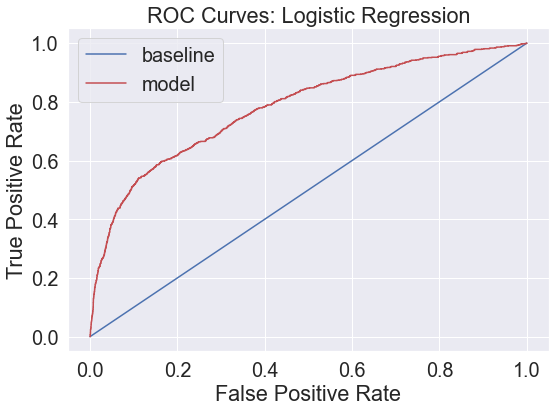

In [127]:
# Use the best model after tuning
best_lr_model = lr_grid.best_estimator_
pipe_best_lr_model = make_pipeline(col_trans, best_lr_model)
pipe_best_lr_model.fit(X_train, y_train)
y_pred_best_lr_model = pipe_best_lr_model.predict(X_test)
pprint(best_lr_model.get_params())

train_lr_predictions = pipe_best_lr_model.predict(X_train)
train_lr_probs = pipe_best_lr_model.predict_proba(X_train)[:, 1]
lr_probs = pipe_best_lr_model.predict_proba(X_test)[:, 1]
# Plot ROC curve and check scores
evaluate_model(y_pred_best_lr_model, lr_probs, train_lr_predictions, train_lr_probs, title_name="Logistic Regression")

In [103]:
print(f'Train ROC AUC Score: {roc_auc_score(y_train, train_lr_probs)}')
print(f'Test ROC AUC  Score: {roc_auc_score(y_test, lr_probs)}')

Train ROC AUC Score: 0.7694587387199893
Test ROC AUC  Score: 0.7814991687097267


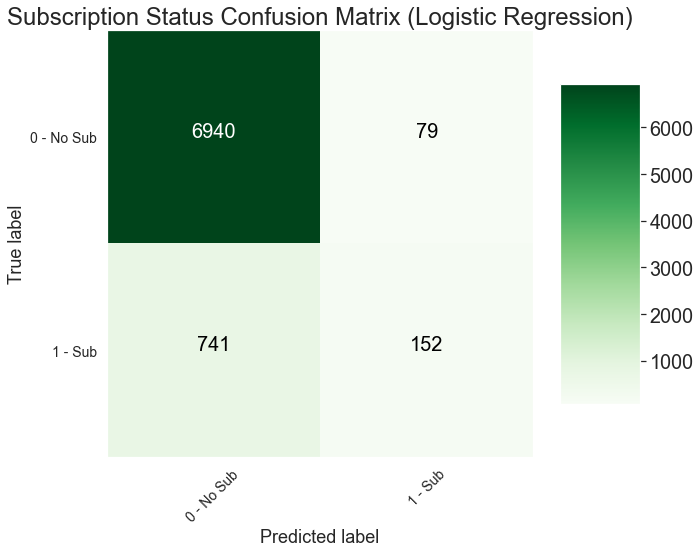

In [116]:
# Plot Confusion matrix
plot_confusion_matrix(confusion_matrix(y_test, y_pred_best_lr_model), classes = ['0 - No Sub', '1 - Sub'],
                      title = 'Subscription Status Confusion Matrix (Logistic Regression)')

In [105]:
#Testing xgboost Model
#Using source: https://www.kaggle.com/phunter/xgboost-with-gridsearchcv
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold

In [106]:
#same as above but using xgboost

# Create base model to tune
xgb_model = xgb.XGBClassifier()

pprint(xgb_model.get_params())

{'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'enable_categorical': False,
 'gamma': None,
 'gpu_id': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_delta_step': None,
 'max_depth': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'objective': 'binary:logistic',
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'use_label_encoder': True,
 'validate_parameters': None,
 'verbosity': None}


In [107]:
xgb_param = {'nthread':[8], #when use hyperthread, xgboost may become slower
              'objective': ['binary:logistic'],
              'learning_rate': [0.01, 0.05, 0.1, 0.5], #so called `eta` value
              'max_depth': [4, 8, 12],
              'seed': [42]
              }

In [108]:
# Create random search model and fit the data
xgb_grid = GridSearchCV(
                        estimator = xgb_model,
                        param_grid = xgb_param,
                        n_jobs = 5, 
                        cv = 3,
                        verbose=1,  
                        scoring='roc_auc')
xgb_grid.fit(X_train_encoded, y_train)
xgb_grid.best_params_
xgb_grid.best_params_

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  36 out of  36 | elapsed:   56.6s finished
C:\Users\Andrew\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:32:14] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


{'learning_rate': 0.1,
 'max_depth': 4,
 'nthread': 8,
 'objective': 'binary:logistic',
 'seed': 42}

C:\Users\Andrew\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:13:18] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'enable_categorical': False,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 4,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 8,
 'nthread': 8,
 'num_parallel_tree': 1,
 'objective': 'binary:logistic',
 'predictor': 'auto',
 'random_state': 42,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 42,
 'subsample': 1,
 'tree_method': 'exact',
 'use_label_encoder': True,
 'validate_parameters': 1,
 'verbosity': None}
Recall
            Baseline: 1.0
         

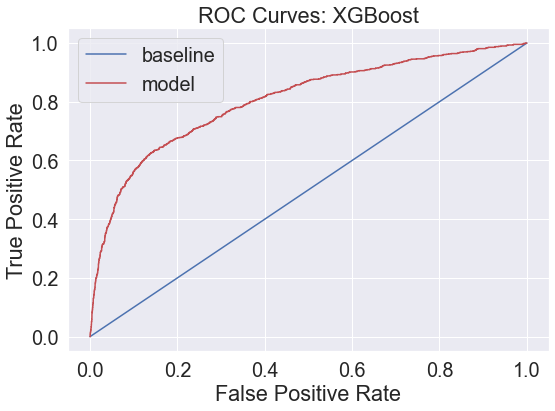

In [128]:
# Use the best model after tuning
best_xgb_model = xgb_grid.best_estimator_
pipe_best_xgb_model = make_pipeline(col_trans, best_xgb_model)
pipe_best_xgb_model.fit(X_train, y_train)
y_pred_best_xgb_model = pipe_best_xgb_model.predict(X_test)
pprint(best_xgb_model.get_params())

train_xgb_predictions = pipe_best_xgb_model.predict(X_train)
train_xgb_probs = pipe_best_xgb_model.predict_proba(X_train)[:, 1]
xgb_probs = pipe_best_xgb_model.predict_proba(X_test)[:, 1]
# Plot ROC curve and check scores
evaluate_model(y_pred_best_xgb_model, xgb_probs, train_xgb_predictions, train_xgb_probs, title_name="XGBoost")

In [110]:
print(f'Test ROC AUC  Score: {roc_auc_score(y_test, xgb_probs)}')
print(f'Train ROC AUC Score: {roc_auc_score(y_train, train_xgb_probs)}')

Test ROC AUC  Score: 0.8058647245590158
Train ROC AUC Score: 0.8305532001566496


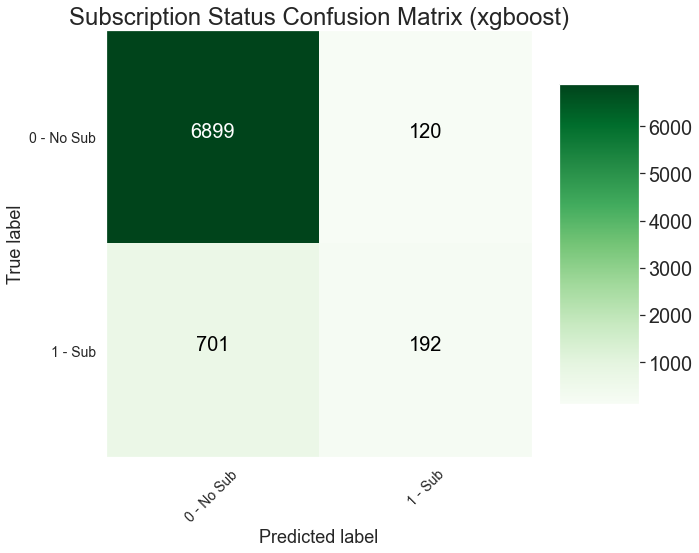

In [117]:
# Plot Confusion matrix
plot_confusion_matrix(confusion_matrix(y_test, y_pred_best_xgb_model), classes = ['0 - No Sub', '1 - Sub'],
                      title = 'Subscription Status Confusion Matrix (xgboost)')

# creating a unified ROC-AUC curve

In [ ]:
#adapted from: https://github.com/ithisted/PetAdoptionPrediction/blob/master/PetAdoptionPrediction.ipynb
'''
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(12,8))

for fpr, tpr, model in [(lr_fpr,lr_tpr,'Logistic Regression'),(rf_fpr,rf_tpr,'Random Forest'),(gb_fpr,gb_tpr,'Gradient Boosting')]:
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr,
             lw=2, label='ROC '+ model + ' (area = %0.2f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC comparison')
plt.legend(loc="lower right")
plt.show()

'''

# saving each model set to CSV file

# Selecting best model to use

In [112]:
df_test.shape

(13564, 20)

In [113]:
df_test['random'] = np.random.random(size = df_t.shape[0]) #adding a random column for a baseline on feature importances

X_test = df_test[features]
y_test = df_test['y_bool']

NameError: name 'df_t' is not defined

In [ ]:
final_y = pipe_best_model.predict(X_test)

In [ ]:
final_report = df_test
final_report['subscription_prediction'] = final_y
final_report = final_report.loc[:,['y_bool', 'subscription_prediction']]

# Replace 1-0 with Yes-No to make it interpretable
final_report= final_report.replace(1, 'Yes')
final_report= final_report.replace(0, 'No')

In [ ]:
final_report = final_report.rename(columns={'y_bool':'True Value', 'subscription_prediction': 'Predicted Value'})
final_report

In [ ]:
final_report.value_counts()

# Determining profitability curve